<a href="https://colab.research.google.com/github/KurohaMoonlight/KurohaMoonlight/blob/main/tugas_pola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mengekstrak Data Set
# 1. Upload File DataSet.zip ke Direktori
from zipfile import ZipFile

file_name = "/content/drive/MyDrive/archive.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
print('Done')

Done


In [ ]:
# -*- coding: utf-8 -*-
"""
tugas_pola_pol_rill_simplified.ipynb

Automatically generated by Colab.
"""

# Impor library yang relevan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, itertools
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tqdm.notebook import tqdm

# --- 1. Memuat dan Mempersiapkan Dataset ---
base_dir = '/content/animals/animals'
categories = os.listdir(base_dir)
num_classes = len(categories)
print(f"Total Kelas: {num_classes}")

# Membuat DataFrame dari path gambar dan label
image_paths, labels = [], []
for category in tqdm(os.listdir(base_dir)):
    for img_filepath in os.listdir(os.path.join(base_dir, category)):
        image_paths.append(os.path.join(base_dir, category, img_filepath))
        labels.append(category)

df = pd.DataFrame({'image_filepath': image_paths, 'label': labels})

# Melakukan pemisahan data train-validation-test
train_df, temp_df = train_test_split(df, train_size=0.7, stratify=df['label'], random_state=101)
val_df, test_df = train_test_split(temp_df, train_size=0.7, stratify=temp_df['label'], random_state=101)

print(f"Bentuk Data: Train={train_df.shape}, Validation={val_df.shape}, Test={test_df.shape}")

# --- 2. Membuat Generator Data Gambar ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data_generator = generator.flow_from_dataframe(
    train_df, x_col='image_filepath', y_col='label', class_mode='categorical',
    shuffle=True, batch_size=BATCH_SIZE, target_size=IMG_SIZE
)

val_data_generator = generator.flow_from_dataframe(
    val_df, x_col='image_filepath', y_col='label', class_mode='categorical',
    shuffle=False, batch_size=BATCH_SIZE, target_size=IMG_SIZE
)

test_data_generator = generator.flow_from_dataframe(
    test_df, x_col='image_filepath', y_col='label', class_mode='categorical',
    shuffle=False, batch_size=BATCH_SIZE, target_size=IMG_SIZE
)

# --- 3. Membangun Model ---
# Muat model dasar EfficientNetB0
efficient_net_model = EfficientNetB0(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max'
)
efficient_net_model.trainable = False # Bekukan semua layer pada awalnya

# Buat model lengkap dengan lapisan augmentasi dan klasifikasi
inputs = Input(shape=(224, 224, 3))
x = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
], name='augmentation_layer')(inputs)
x = efficient_net_model(x, training=False)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(units=num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

# Kompilasi model untuk transfer learning
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])
model.summary()

# --- 4. Pelatihan Awal (Transfer Learning) ---
print("\n--- Memulai Transfer Learning ---")
r = model.fit(
    train_data_generator,
    validation_data=val_data_generator,
    epochs=15, # Mengurangi epoch untuk contoh yang lebih cepat
    callbacks=[
        EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=2, verbose=1)
    ]
)

# --- 5. Pelatihan Lanjutan (Fine-Tuning) ---
print("\n--- Memulai Fine-Tuning ---")
# Cairkan beberapa lapisan terakhir dari model dasar
efficient_net_model.trainable = True
for layer in efficient_net_model.layers[:-30]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = False

# Kompilasi ulang model dengan learning rate yang lebih rendah untuk fine-tuning
model.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Lanjutkan pelatihan (fine-tuning)
fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1, start_from_epoch=3),
    ModelCheckpoint(filepath='fine_tuned_animal_classifier.keras', monitor='val_accuracy', mode='max', save_best_only=True)
]

r_fine = model.fit(
    train_data_generator,
    validation_data=val_data_generator,
    epochs=20, # Mengurangi epoch untuk contoh yang lebih cepat
    callbacks=fine_tune_callbacks
)

# --- 6. Visualisasi Performa & Evaluasi Akhir ---
# Ekstrak riwayat dari pelatihan fine-tuning
history = r_fine.history
plt.figure(figsize=(16, 6))
plt.style.use('fivethirtyeight')

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], 'r', label='Training Loss')
plt.plot(history['val_loss'], 'g', label='Validation Loss')
plt.title('Grafik Loss (Fine-Tuned)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], 'r', label='Training Accuracy')
plt.plot(history['val_accuracy'], 'g', label='Validation Accuracy')
plt.title('Grafik Akurasi (Fine-Tuned)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Muat model terbaik yang telah di-fine-tune dan evaluasi
print("\n--- Mengevaluasi Model Terbaik pada Data Uji ---")
best_model = load_model('fine_tuned_animal_classifier.keras')
loss, acc = best_model.evaluate(test_data_generator)
print(f"Test Loss: {loss:.3f}")
print(f"Test Accuracy: {acc:.2f}")

# Prediksi dan Laporan Klasifikasi
y_test = test_data_generator.classes
y_probs = best_model.predict(test_data_generator)
y_pred = np.argmax(y_probs, axis=1)
class_labels = list(test_data_generator.class_indices.keys())

print(f"\nF1 Score (Macro): {f1_score(y_test, y_pred, average='macro'):.3f}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=class_labels))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(18, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Label", fontsize=15)
plt.ylabel("True Label", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/animals/animals'

Model berhasil dimuat.
Silakan unggah gambar hewan untuk diprediksi:


Saving 004d0c2c8e.jpg to 004d0c2c8e.jpg

Memproses: 004d0c2c8e.jpg


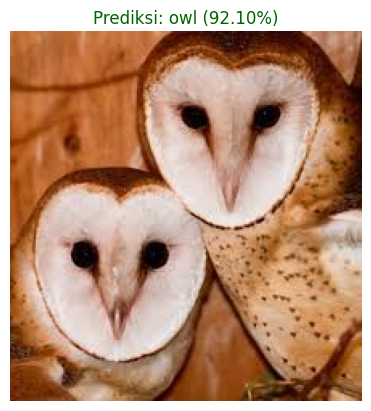

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from google.colab import files
import cv2

# --- Pengaturan Model dan Ukuran Gambar ---
# Pastikan path ini sesuai dengan lokasi model Anda
MODEL_PATH = '/content/drive/MyDrive/MyModel/FIX RILLL/fine_tuned_animal_classifier.keras'
# MODEL_PATH = '/content/fine_tuned_animal_classifier.keras'
IMG_SIZE = (224, 224)

# --- Memuat Model ---
try:
    best_model = load_model(MODEL_PATH)
    print("Model berhasil dimuat.")
except Exception as e:
    print(f"Error saat memuat model: {e}")
    # Anda bisa menambahkan logika untuk mengunggah model jika tidak ditemukan
    # uploaded = files.upload()
    # best_model = load_model(list(uploaded.keys())[0])

# --- Daftar Kelas Hewan ---
# Daftar ini harus sama dengan yang digunakan saat training
class_labels = ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']

# --- Fungsi untuk Prediksi ---
def predict_animal(img_path):
    """
    Fungsi untuk memprediksi hewan dari sebuah gambar.
    """
    try:
        # Memuat dan memproses gambar
        image = load_img(img_path, color_mode='rgb', target_size=IMG_SIZE)
        image_array = img_to_array(image)
        image_array = preprocess_input(image_array)
        image_batch = np.expand_dims(image_array, axis=0)  # Shape: (1, 224, 224, 3)

        # Melakukan prediksi
        prediction = best_model.predict(image_batch, verbose=0)
        predicted_idx = np.argmax(prediction, axis=1)[0]
        predicted_label = class_labels[predicted_idx]
        confidence = prediction[0][predicted_idx]

        # Menampilkan gambar dengan hasil prediksi
        img_display = cv2.imread(img_path)
        img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
        plt.imshow(img_display)
        plt.axis('off')
        plt.title(f"Prediksi: {predicted_label} ({confidence*100:.2f}%)", color='darkgreen')
        plt.show()

        return predicted_label, confidence

    except Exception as e:
        print(f"Error saat memproses gambar {img_path}: {e}")
        return None, 0.0

# --- Mengunggah dan Memprediksi Gambar ---
print("Silakan unggah gambar hewan untuk diprediksi:")
uploaded = files.upload()

if not uploaded:
    print("Tidak ada file yang diunggah.")
else:
    for filename in uploaded.keys():
        print(f"\nMemproses: {filename}")
        predict_animal(filename)

In [3]:
pip install anvil-uplink

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.8 MB/s eta 0:00:00


In [4]:
import anvil.server

anvil.server.connect("server_YGJEVAOUB5SQDOQEGAPE6VML-ZRB3UIKWB6FG2OHP")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [6]:
import anvil.server
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
import io

# --- Pengaturan Model dan Ukuran Gambar ---
IMG_SIZE = (224, 224)
# Pastikan nama file ini sama dengan yang Anda unggah di App Files
MODEL_PATH = '/content/drive/MyDrive/MyModel/FIX RILLL/fine_tuned_animal_classifier.keras'

# --- Memuat Model ---
# Model dimuat sekali saat server dimulai untuk efisiensi.
try:
    print("Mencoba memuat model...")
    best_model = load_model(MODEL_PATH)
    print("Model berhasil dimuat.")
except Exception as e:
    # Jika gagal, model akan menjadi None dan akan ditangani di fungsi prediksi
    print(f"Error kritis saat memuat model: {e}")
    best_model = None

# --- Daftar Kelas Hewan (Pastikan urutannya benar) ---
class_labels = ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']

# --- Fungsi Prediksi yang Dapat Dipanggil ---
# Menandai fungsi ini agar bisa dipanggil dari Klien (Form)
@anvil.server.callable
def classify_image(image_media):
    """
    Fungsi untuk memprediksi hewan dari Anvil Media Object (gambar).
    Fungsi ini sekarang mengembalikan dictionary.
    """
    # Pemeriksaan apakah model sudah berhasil dimuat
    if not best_model:
        return "Error: Model di server tidak berhasil dimuat. Periksa log server."

    try:
        # Mengonversi Anvil Media Object menjadi byte stream
        image_bytes = image_media.get_bytes()
        image = load_img(io.BytesIO(image_bytes), color_mode='rgb', target_size=IMG_SIZE)

        # Memproses gambar untuk prediksi
        image_array = img_to_array(image)
        image_array = preprocess_input(image_array)
        image_batch = np.expand_dims(image_array, axis=0)

        # Melakukan prediksi
        prediction = best_model.predict(image_batch, verbose=0)
        predicted_idx = np.argmax(prediction, axis=1)[0]
        predicted_label = class_labels[predicted_idx]

        # Konversi confidence ke float standar Python agar bisa di-serialize
        confidence = float(prediction[0][predicted_idx])

        # Mengembalikan dictionary sesuai yang diharapkan klien
        return {'label': predicted_label, 'confidence': confidence}

    except Exception as e:
        print(f"Error saat memproses gambar di server: {e}")
        # Mengembalikan pesan error sebagai string
        return f"Error: Terjadi masalah saat prediksi di server - {e}"


Mencoba memuat model...
Model berhasil dimuat.


In [8]:
anvil.server.wait_forever()

KeyboardInterrupt: 